# Model

Consider a system where EVs arrive as a Poisson process of intensity $\lambda$. Each EV has three main characteristics:

* $S$: the required charging time.
* $T$: the sojourn time (counted from its arrival).
* $T'$: the *declared* sojourn time.

Vehicles are served following the EDF algorithm using its *declared* sojourn time instead of the actual one, but they depart whenever their real sojourn time expires. All vehicles are potentially charged if there is still work to be done and they are still in the system (i.e. no curtailing is applied).

The *load* of the system is defined as:

$$\rho = \lambda E[S]$$

And the number of available chargers is $C$. We would like to understand the performance of the system *in overload*, i.e. $\rho>C$.

## EDF behavior

Let $\sigma:=$ remaining service time, $\tau:=$remaining sojourn time and $\tau':=$ remanining declared sojourn time. Assume that the system is in overload. Using a mean field "ansatz", a threshold should emerge, $\tau^*$, where vehicles are served if their *remaining sojourn time* is below $\tau^*$. For this analysis, we will assume that $\tau^*$ is a constant.

The following diagrams depict several possible charging scenarios for a given vehicle:

![caso 1](caso1.png) ![caso 2](caso2.png)
![caso 3](caso3.png)
![caso 4](caso4.png)

From the above discussion, a vehicle becomes prioritized at time $t+T'-\tau^*$ and starts service. Its service ends whenever it reaches full charge or departs at time $t+T$. Therfore its service time is $\min\{S,T-T'+\tau^*\}$. However, as it is shown in the last example, if $T-T'+\tau^*<0$ it departs before getting any service. We thus have the following expression for the attained service $S_a$:

$$S_a = \min\{S, (T-T'+\tau^*)^+\}.$$

**Note:** a further case appears, whenever the vehicle has such a small $T'$ that it is already below the threshold on arrival. In that case, the vehicle gets immediate priority, and the service would be $\min\{S,T\}$. However, if we assume that $T>S$ a.s. then the above equation still holds (since $-T'+\tau^*>0$, the second term is larger than $T$ and therefore $S$).

## Fixed point equation

Following our mean field "ansatz", the total work performed by the system cannot be larger than $C$, and therefore we have the following fixed point equation for the threshold:

$$\lambda E[S_a] = \lambda E[\min\{S, (T-T'+\tau^*)^+\}] = C.$$

Let us now solve this fixed point equation under some distributional assumptions on $S, T, T'$. Assume that:

* $S\sim \exp(\mu)$.
* $T=S+L$ with $L\sim\exp(\gamma)$ is independent of $S$ and is the *laxity* the user provides.
* $T' = T + U$ where $U$ is an uncertainity distribution. For instance $U=\theta Z$ with $Z\sim N(0,1)$, or $U\sim U[-\theta,\theta]$. In both cases $\theta$ acts as an uncertainty paramter.

### Lemma:

The following expectation can be readily computed for any exponential random variable with parameter $\mu$:

$$E[\min\{S,x\}] = \int_0^x e^{-\mu x}dx = \frac{1}{\mu}(1-e^{-\mu x}).$$

### The uniform uncertainty case:

Assume that $U\sim U[-\theta,\theta]$. in that case $X=T-T'+\tau^* \sim U[\tau^*-\theta,\tau^*+\theta]$. Using the above lemma we can compute:

$$\begin{align}
E[\min\{S, (T-T'+\tau^*)^+\}] &= E[E[\min\{S,X\}\mid X]] \\
&= E\left[ \frac{1}{\mu}(1-e^{-\mu X}) \right] \\
&= \int_{\tau^*-\theta}^{\tau^*+\theta} \frac{1}{\mu}(1-e^{-\mu x}) \frac{1}{2\theta} dx \\
&= \frac{1}{\mu} - \int_{\tau^*-\theta}^{\tau^*+\theta} \frac{e^{-\mu x}}{\mu} \frac{1}{2\theta} dx \\
&= \frac{1}{\mu} - \frac{1}{2\mu^2\theta}\left(e^{-\mu(\tau^*-\theta)} - e^{-\mu(\tau^*+\theta)} \right) \\
&= \frac{1}{\mu} - \frac{e^{-\mu\tau^*}}{2\mu^2\theta}\left(e^{\mu\theta} - e^{-\mu\theta} \right) \\
&= \frac{1}{\mu}\left(1-e^{-\mu\tau^*}\frac{\sinh(\mu\theta)}{\mu\theta}\right).
\end{align}$$

The above equation is valid whenever $\tau^*>\theta$ and with a suitable correction can be extended for the other case.

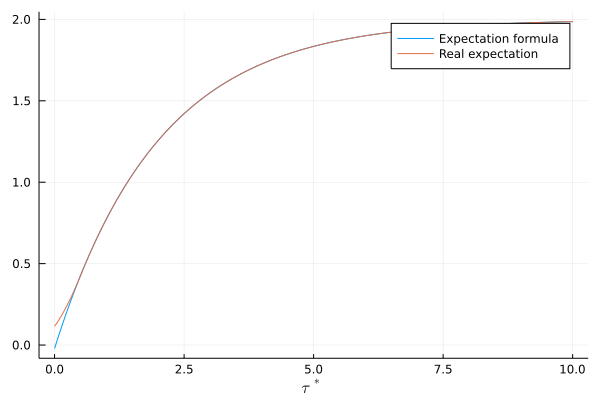

In [13]:
using Plots, LaTeXStrings

theta = 0.5
mu=0.5
tau = (0:.01:10)
E = 1/mu*(1.0.-exp.(-mu*tau).*sinh.(mu*theta)/(mu*theta))

function esperanza_u(tau,mu,theta)
    1/mu*(tau+theta-max(tau-theta,0))/(2*theta) - 1/(2*mu^2*theta)* (exp(-mu*max(tau-theta,0)) - exp(-mu*(tau+theta)) )
end

plot(tau,E, xlabel=L"\tau^*", label="Expectation formula")
plot!(tau, esperanza_u.(tau,mu,theta), label="Real expectation")

With the above formula at hand, we can compute the threshold for a given $\lambda,C$ as follows:

$$\lambda \frac{1}{\mu}\left(1-e^{-\mu\tau^*}\frac{\sinh(\mu\theta)}{\mu\theta}\right) = C$$

So:

$$1-e^{-\mu\tau^*}\frac{\sinh(\mu\theta)}{\mu\theta} = \frac{C}{\rho},$$

and therefore:
$$e^{-\mu\tau^*} = \frac{\mu\theta (1-C/\rho)}{\sinh(\mu\theta)},$$

and finally:

$$\tau^* = -\frac{1}{\mu} \log\left(\frac{\mu\theta (1-C/\rho)}{\sinh(\mu\theta)} \right).$$

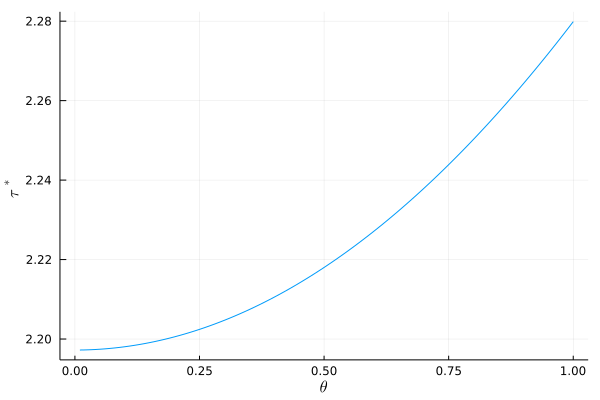

In [16]:
function threshold(theta,lambda,mu,C)
    rho = lambda/mu
    return -1/mu*log( mu*theta*(1-C/rho)/sinh(mu*theta))
end

theta=(0:.01:1)
lambda=30
mu=0.5
C=40

tau = threshold.(theta,lambda,mu,C)

plot(theta,tau ,xlabel = L"\theta", ylabel=L"\tau^*", label=:none)

### Attained service by EDF under uncertainty

The above shows that having uncertainty in the deadlines impacts on system performance. From the fixed point equation, we know that the threshold would adapt so that the total attained service verifies:

$$\lambda E[S_a] = C.$$

Normalizing by the average service demand $E[S]$ we get:

$$\frac{E[S_a]}{E[S]} = \frac{C}{\rho}.$$

This is satisfied by any efficient policy in overload. However, it is interesting to plug-in the threshold analysis to understand the average performance for a given deviation in $T'-T$.

To do so, recall that:

$$S_a = \min\{S,(T-T'+\tau^*)^+\}.$$

For a given load $\rho$, uncertainty parameter $\theta$ and capacity $C$ we can compute the corresponding threshold $\tau^*$ as before. Then we can analyze:

$$E[S_a\mid T'-T] = E[S_a\mid U] = E[\min\{S,(-U+\tau^*)^+\} \mid U] = \frac{1-e^{-\mu(-U+\tau^*)^+}}{\mu}$$

where in the last step we used the same Lemma as before.

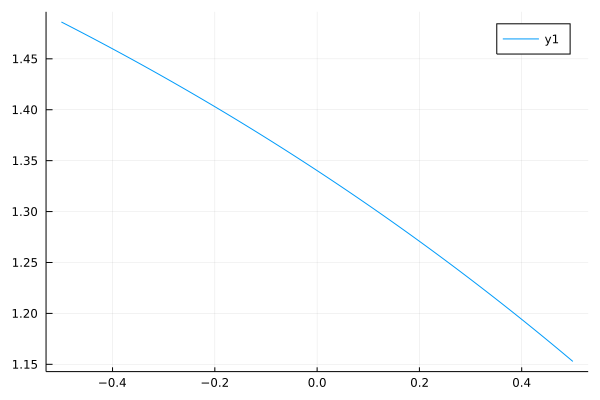

In [23]:
theta=(0:.01:1)
lambda=30
mu=0.5
C=40

theta = 0.5

tau = threshold(theta,lambda,mu,C)

U=-theta:.0001:theta
Sa = (1.0 .-exp.(-mu*max.(-U.+tau,0)))/mu
plot(U,Sa)

An EV simulation with:
	TotalArrivals: 		 3099
	AvgReportedDeadline: 		 NaN
	Snapshots: 		 1
	AvgEnergy: 		 1.984920229421804
	Policy: 		 EDF
	AvgDeadline: 		 6.073664588903288
	SimTime: 		 107.92730869626476
	Capacity: 		 40.0


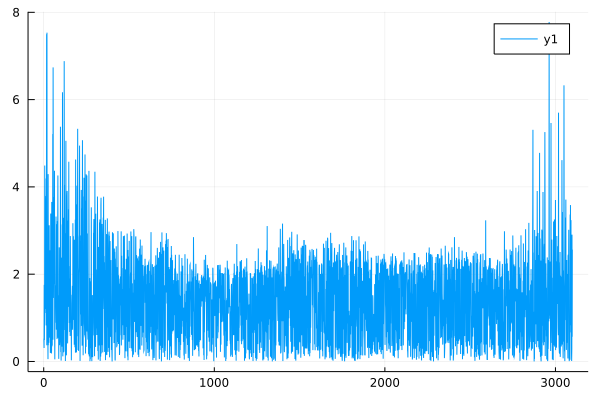

In [38]:
using EVQueues, DataFrames

gamma=0.25
Tfinal = 100

stream = generate_Poisson_stream(lambda,mu,gamma,Tfinal)

sim = ev_edf_trace(stream,40.0)
show(sim)

simEVs = sort(sim.EVs, by=x->x.arrivalTime)

Sa = [ev.requestedEnergy-ev.departureWorkload for ev in simEVs];

In [44]:
using Distributions

stream2 = deepcopy(stream)

theta=0.5

stream2[!,:salidaReportada] = stream2[!,:salidas] + rand(Uniform(-theta,theta),nrow(stream2))


sim2 = ev_edf_trace(stream2,40.0)
show(sim2)

sim2EVs = sort(sim2.EVs, by=x->x.arrivalTime)

Sa2 = [ev.requestedEnergy-ev.departureWorkload for ev in sim2EVs];

An EV simulation with:
	TotalArrivals: 		 3099
	AvgReportedDeadline: 		 6.072463567637953
	Snapshots: 		 1
	AvgEnergy: 		 1.984920229421804
	Policy: 		 EDF
	AvgDeadline: 		 6.073664588903288
	SimTime: 		 107.92730869626476
	Capacity: 		 40.0


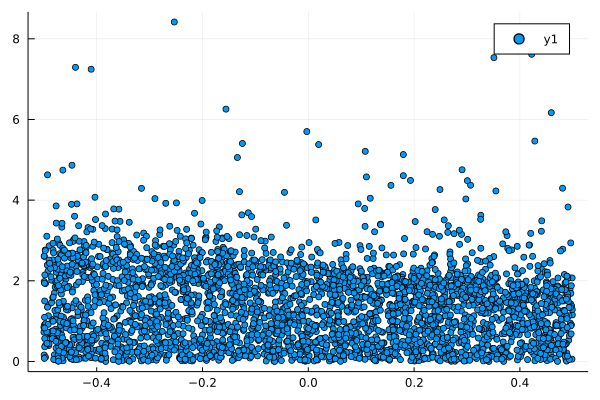

In [47]:
U = stream2[!,:salidaReportada] - stream2[!,:salidas]

scatter(U,Sa2)

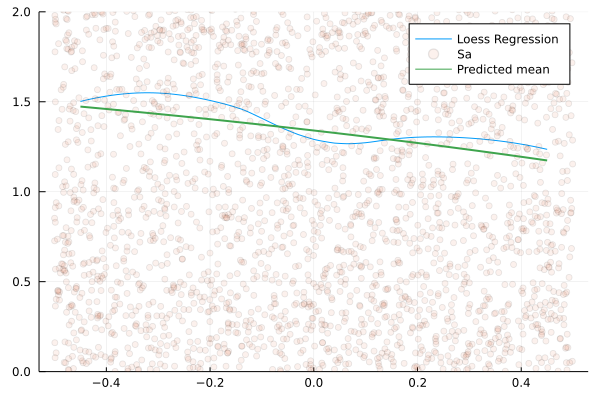

In [66]:
using Loess

model = loess(U,Sa2, span=0.75)
u=(-0.9*theta:.01:0.9*theta)
fit = predict(model,u)

tau = threshold(theta,lambda,mu,C)
Sa_teo = (1.0 .-exp.(-mu*max.(-u.+tau,0)))/mu

plot(u,fit, label="Loess Regression")
scatter!(U,Sa,alpha=0.1, ylims=(0,2), label="Sa")
plot!(u,Sa_teo,lw=2, label="Predicted mean")